### Importing modules

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

### 1. Dataset Download

In [222]:
df=pd.read_csv('winequality-white.csv',delimiter=';')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


### 2. Preprocessing

In [223]:
print("NUll values:", sum(df.isna().sum()))
print("Duplicate rows: ",df.duplicated().sum())
df=df.drop_duplicates().reset_index(drop=True)
print(df.shape)
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
print(df.columns)

NUll values: 0
Duplicate rows:  937
(3961, 12)
Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [224]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR)))
outlier_counts = outliers.sum().sort_values(ascending=False)
outlier_counts


chlorides               178
volatile_acidity        133
fixed_acidity           106
sulphates                96
ph                       46
residual_sugar           16
total_sulfur_dioxide     14
density                   6
alcohol                   0
dtype: int64

In [225]:
df = df.drop(['citric_acid', 'free_sulfur_dioxide'], axis=1)


In [226]:
corr_with_target = df.corr()['quality'].sort_values(key=abs, ascending=False)
corr_with_target


quality                 1.000000
alcohol                 0.462869
density                -0.337805
chlorides              -0.217739
volatile_acidity       -0.190678
total_sulfur_dioxide   -0.183356
fixed_acidity          -0.124636
ph                      0.123829
residual_sugar         -0.117339
sulphates               0.053200
Name: quality, dtype: float64

In [227]:
X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [229]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'residual_sugar', 'chlorides',
       'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

### 3. EDA

3.1 Univariate

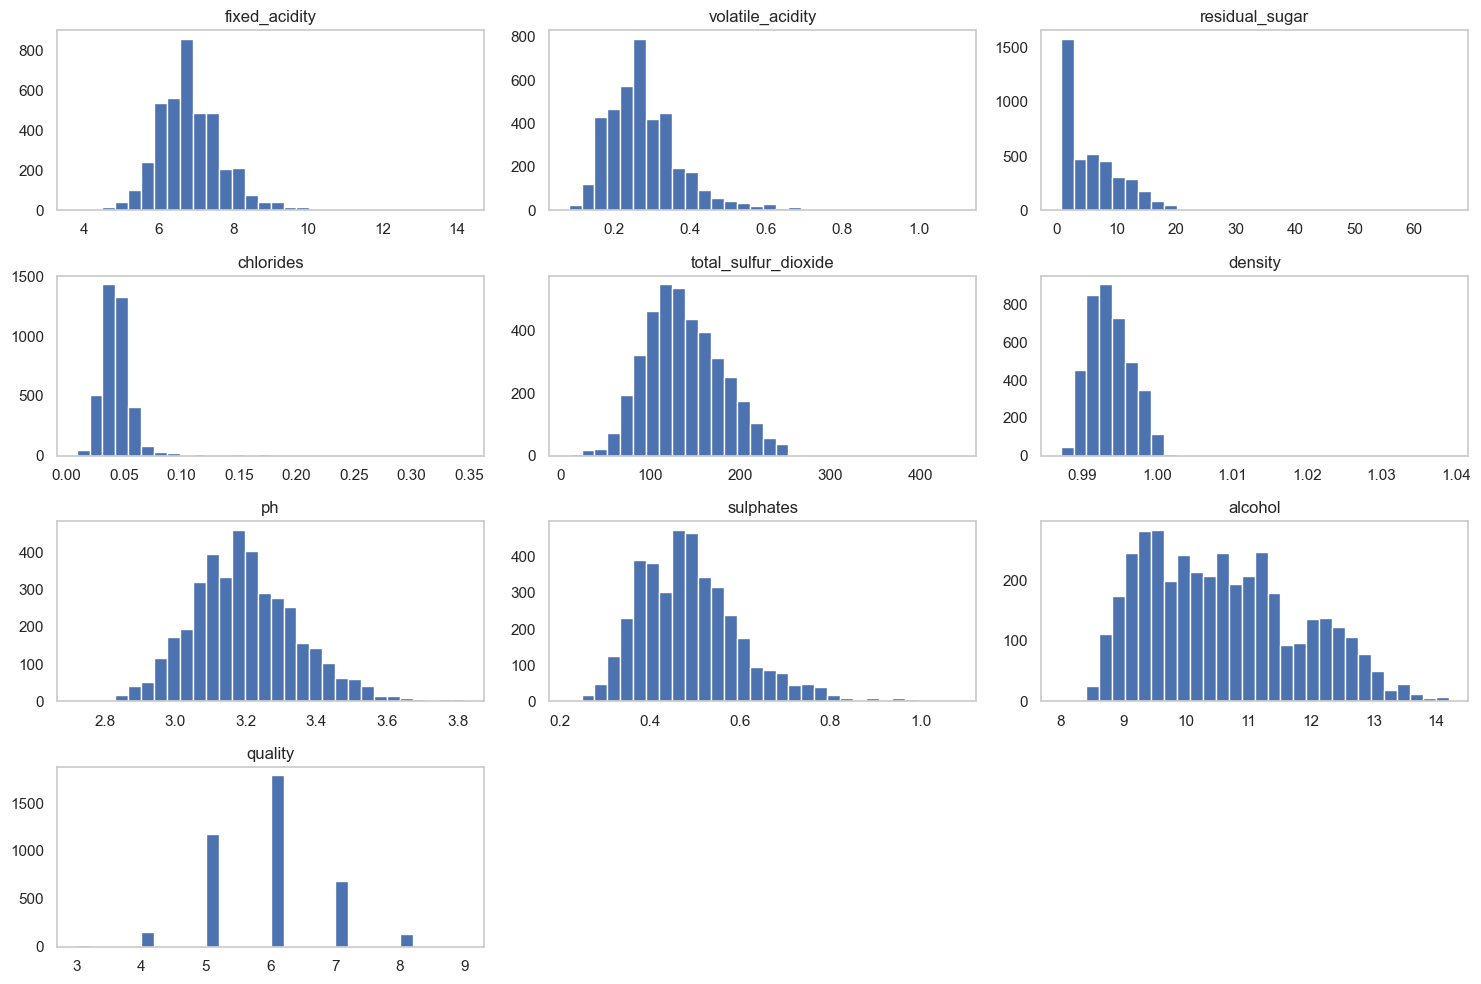

In [230]:
df.hist(bins=30, figsize=(15,10),grid=False)
plt.tight_layout()
plt.show()


3.2 Multivariate

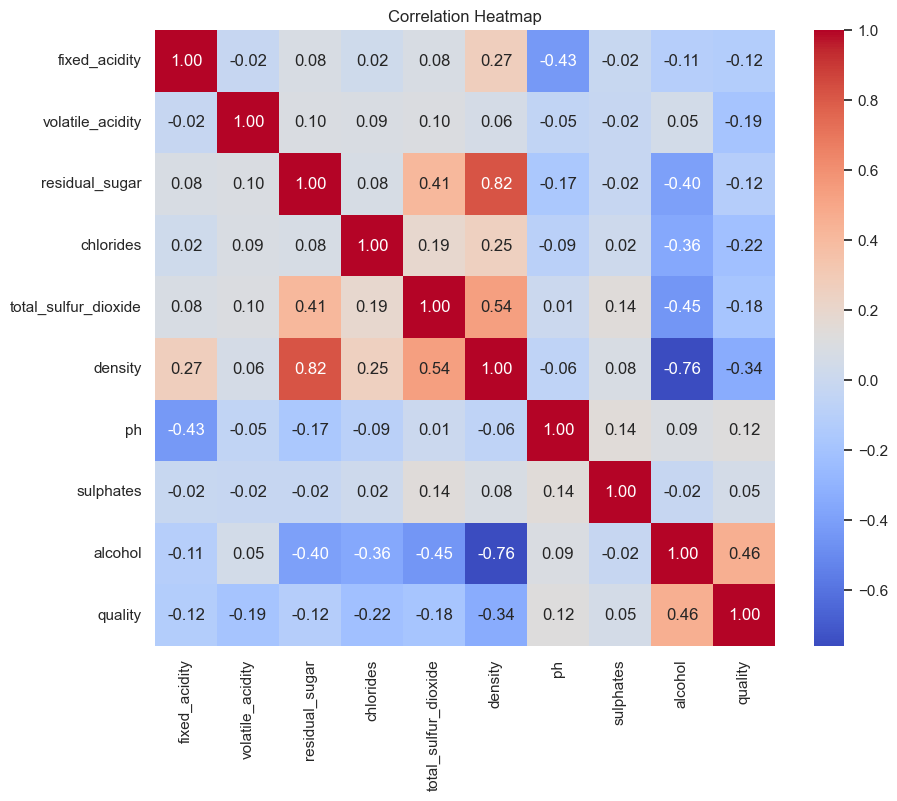

In [231]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


### 4. Linear Regression

In [232]:
lr=LinearRegression()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_test = r2_score(y_test, y_pred)
r2_train = lr.score(X_train, y_train)
gap = r2_train-r2_test

print(mae,mse,rmse,r2_test,r2_train,gap)

0.5971159618179211 0.5984692369845382 0.7736079349286292 0.2702724238593198 0.29872916045292364 0.028456736593603815


4.1 coeff of features

In [233]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(coef_df)


                Feature  Coefficient
5               density  -124.151371
1      volatile_acidity    -1.963032
6                    ph     0.671017
7             sulphates     0.583717
3             chlorides    -0.243673
8               alcohol     0.238552
2        residual_sugar     0.066935
0         fixed_acidity     0.031756
4  total_sulfur_dioxide     0.001009


5. Multicollinearity & Assumptions 

In [234]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_top3 = vif_data.sort_values(by="VIF", ascending=False).head(3)

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()
residuals = model.resid

shapiro_p = shapiro(residuals).pvalue
dw_stat = sm.stats.stattools.durbin_watson(residuals)
bp_p = het_breuschpagan(residuals, model.model.exog)[1]

print(vif_top3,"\n-----------\n", shapiro_p, "\n-----------\n",dw_stat,"\n--------------\n", bp_p)


   Feature          VIF
5  density  1037.526813
6       ph   599.742487
8  alcohol   115.027607 
-----------
 6.723329296173405e-16 
-----------
 1.7612951738654536 
--------------
 3.7949075926113306e-19


### 6. Tuning

6.1 Polynomial Regression

6.1.1 using alcohol feature only

In [236]:
from sklearn.model_selection import GridSearchCV
X_cv=X_train['alcohol'].values.reshape(-1,1)
y_cv=y_train[:].values
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('model', LinearRegression())
])

param_grid = {
    'poly__degree': [1,2,3,4,5,6,7,8,9,10]
}

grid_f1 = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_f1.fit(X_cv, y_cv)


best_degree = grid_f1.best_params_['poly__degree']
best_cv_r2 = grid_f1.best_score_

best_degree, best_cv_r2


(3, np.float64(0.21367899400383705))

6.1.2 Using all features

In [237]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('model', LinearRegression())
])

param_grid = {
    'poly__degree': [1,2,3,4,5,6]
}

grid_f1 = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_f1.fit(X_train, y_train)


best_degree = grid_f1.best_params_['poly__degree']
best_cv_r2 = grid_f1.best_score_

best_degree, best_cv_r2




(2, np.float64(0.32637753221780075))

6.1.2.1 metrics of best estimator of polynomial regression


In [241]:
model=grid_f1.best_estimator_

model.fit(X_train,y_train)
y_pred=model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_test = r2_score(y_test, y_pred)
r2_train = model.score(X_train, y_train)
gap = r2_train-r2_test

print(mae,mse,rmse,r2_test,r2_train,gap)


0.5954744106071982 0.5846337765631261 0.764613481808375 0.28714232522463967 0.36773406548446197 0.0805917402598223


6.2 Ridge Regression

In [ ]:
pipeline_ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree)),
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

param_grid_ridge = {'model__alpha': [0.01, 0.1, 1, 10]}
grid_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)

ridge_best_alpha = grid_ridge.best_params_['model__alpha']
ridge_r2_test = grid_ridge.score(X_test, y_test)

ridge_best_alpha, ridge_r2_test

(10, 0.29234837832052984)

6.3 Lasso Regression

In [ ]:
pipeline_lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree)),
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

param_grid_lasso = {'model__alpha': [0.01, 0.1, 1, 10]}
grid_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)

lasso_best_alpha = grid_lasso.best_params_['model__alpha']
lasso_r2_test = grid_lasso.score(X_test, y_test)
lasso_n_nonzero = np.sum(grid_lasso.best_estimator_.named_steps['model'].coef_ != 0)

lasso_best_alpha, lasso_r2_test, lasso_n_nonzero

(0.01, 0.27017096404348584, np.int64(17))

6.4 Cross Validation

In [ ]:


cv_folds = 3
r2_scores = cross_val_score(grid_ridge.best_estimator_, X_train, y_train, cv=cv_folds, scoring='r2')
rmse_scores = np.sqrt(-cross_val_score(grid_ridge.best_estimator_, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error'))

r2_mean = r2_scores.mean()
r2_std = r2_scores.std()
rmse_mean = rmse_scores.mean()
rmse_std = rmse_scores.std()

train_r2 = grid_ridge.best_estimator_.score(X_train, y_train)
if train_r2 - r2_mean > 0.1:
    note = "High variance (overfit)"
elif train_r2 < 0.3:
    note = "High bias (underfit)"
else:
    note = "Fit looks good"

cv_folds, r2_mean, r2_std, rmse_mean, rmse_std, note


(3,
 np.float64(0.3070147098585753),
 np.float64(0.014880386201387616),
 np.float64(0.7379206669319974),
 np.float64(0.007581283208219478),
 'Fit looks good')